<a href="https://colab.research.google.com/github/anhquan-ngg/DataScienceProject/blob/main/Loan_Repayment_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Mount Google Drive to load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

# Install extra lib
!pip install xgboost
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [20]:
df_loan = pd.read_csv("/content/drive/MyDrive/Dataset/loan_data.csv")
df_loan.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,credit_card,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0
1,1,home_improvement,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0
2,1,credit_card,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0
3,1,credit_card,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0
4,1,debt_consolidation,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1


#EDA (Exploratory Data Analysis)

In [21]:
df_loan.count()

credit_policy        37066
purpose              37066
int_rate             37066
installment          37066
log_annual_inc       37066
dti                  36966
fico                 37066
days_with_cr_line    37066
revol_bal            37066
revol_util           37054
inq_last_6mths       37066
delinq_2yrs          37032
pub_rec              37066
not_fully_paid       37066
dtype: int64

In [22]:
df_loan[df_loan.isna().any(axis = 1)]

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
251,1,credit_card,0.143,1201.33,0.0,NaN,679,42156,16858,0.371,1,0.000,2,1
1554,1,credit_card,0.088,826.66,0.0,NaN,709,38353,47472,0.682,1,0.000,0,0
1805,1,debt_consolidation,0.124,167.03,38000.0,5.56,689,39052,0,NaN,0,0.000,0,0
2226,1,home_improvement,0.082,814.70,120000.0,9.25,764,37987,0,NaN,0,0.000,0,0
2345,1,debt_consolidation,0.131,797.80,0.0,NaN,814,37316,97,0.016,0,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35967,1,house,0.082,1256.97,0.0,NaN,709,31686,0,0.000,278568,0.544,0,1
35969,1,home_improvement,0.139,928.66,1.0,NaN,709,33848,0,0.000,1648,0.323,0,1
36356,1,debt_consolidation,0.250,59.64,60000.0,9.40,719,39234,0,0.000,0,NaN,0,1
36503,1,credit_card,0.065,1225.24,0.0,NaN,739,30864,0,0.000,55481,0.937,0,1


In [23]:
# Drop all Nan rows
df_loan.dropna(inplace = True)

not_fully_paid
1    26775
0    10145
Name: count, dtype: int64


<Axes: xlabel='not_fully_paid'>

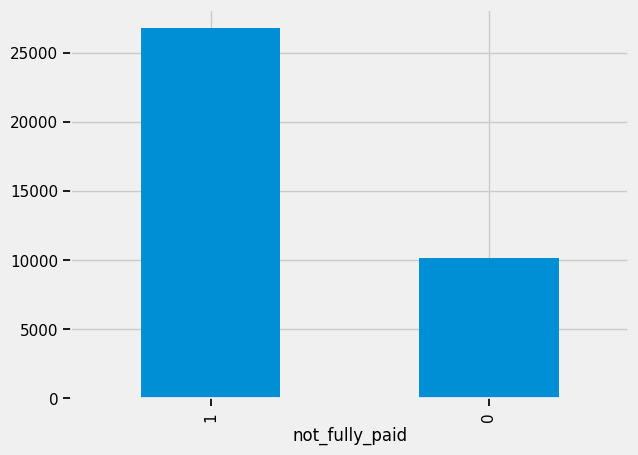

In [24]:
# Statisc about repaid loans
# 0: The loan is not repaid
# 1: The loan is repaid

print(df_loan['not_fully_paid'].value_counts())
df_loan['not_fully_paid'].value_counts().plot(kind = 'bar')

# Imbalanced data -> pre-processing before training model

# Pre-processing data

In [25]:
# Find field is Object/String -> Only Purpose Column -> Pre-processing using One Hot Encoding
object_cols = [f for f in df_loan.columns if df_loan[f].dtype == 'O']
print(object_cols)

['purpose']


In [26]:
df_loan['purpose'].value_counts()

purpose
debt_consolidation    19516
credit_card            9087
home_improvement       2836
other                  2496
major_purchase          899
medical                 465
house                   406
car                     384
vacation                313
small_business          269
moving                  234
renewable_energy         15
Name: count, dtype: int64

In [27]:
def process_purpose(x):
  if x == "debt_consolidation":
    return 1
  return 0

df_loan["purpose_int"] = df_loan["purpose"].apply(process_purpose)


In [28]:
df_loan["purpose_int"].value_counts()

purpose_int
1    19516
0    17404
Name: count, dtype: int64

In [29]:
# Drop purpose
df_loan.drop(columns = ["purpose"], inplace = True)
df_loan.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
0,1,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0,0
1,1,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0,0
2,1,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0,0
3,1,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0,0
4,1,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1,1


In [30]:
df_loan['credit_policy'].value_counts()

credit_policy
1    36920
Name: count, dtype: int64

In [31]:
# Drop credit_policy because variance of this column is 0
df_loan.drop(columns = ["credit_policy"], inplace = True)
df_loan.head()

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
0,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0,0
1,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0,0
2,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0,0
3,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0,0
4,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1,1


In [32]:
# Check correlation ? -> Keep all input
corr = df_loan.corr()
corr.style.background_gradient(cmap = 'coolwarm')


,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
int_rate,1.000000,0.042739,-0.055919,0.116065,-0.456244,0.086726,0.021824,0.133468,-0.003504,0.172759,0.046075,-0.036599,0.097478
installment,0.042739,1.000000,0.227242,0.084286,0.022387,-0.125390,0.170643,0.028539,0.226005,0.046695,-0.049956,-0.013016,0.140044
log_annual_inc,-0.055919,0.227242,1.000000,-0.121779,0.020853,-0.119594,0.151355,0.044720,0.177392,0.029868,-0.034424,-0.037026,-0.002927
dti,0.116065,0.084286,-0.121779,1.000000,-0.013244,-0.044598,0.077765,0.000342,0.081434,0.032497,-0.010775,-0.031361,0.054696
fico,-0.456244,0.022387,0.020853,-0.013244,1.000000,-0.120728,-0.021722,-0.188516,-0.065700,-0.307689,-0.191167,-0.027124,-0.024893
days_with_cr_line,0.086726,-0.125390,-0.119594,-0.044598,-0.120728,1.000000,-0.066180,-0.068710,-0.187349,-0.052515,-0.006409,-0.038029,-0.006357
revol_bal,0.021824,0.170643,0.151355,0.077765,-0.021722,-0.066180,1.000000,0.128898,-0.203446,-0.146972,-0.067585,-0.356469,0.029699
revol_util,0.133468,0.028539,0.044720,0.000342,-0.188516,-0.068710,0.128898,1.000000,-0.061745,-0.014098,-0.052424,-0.086816,0.004182
inq_last_6mths,-0.003504,0.226005,0.177392,0.081434,-0.065700,-0.187349,-0.203446,-0.061745,1.000000,0.220876,-0.056046,0.219629,-0.007000
delinq_2yrs,0.172759,0.046695,0.029868,0.032497,-0.307689,-0.052515,-0.146972,-0.014098,0.220876,1.000000,-0.030163,0.135084,0.007397


In [33]:
# Scale data

input_field = df_loan.drop(columns = ['not_fully_paid']).columns.values
input_field

array(['int_rate', 'installment', 'log_annual_inc', 'dti', 'fico',
       'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths',
       'delinq_2yrs', 'pub_rec', 'purpose_int'], dtype=object)

In [34]:
X = df_loan[input_field]
y = df_loan["not_fully_paid"]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X[input_field])
X[input_field] = scaler.transform(X[input_field])

<ipython-input-34-76806e5cdd0f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[input_field] = scaler.transform(X[input_field])


In [35]:
X.head()

,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_int
0,0.352941,0.285030,0.016129,0.015716,0.161290,0.760027,0.039118,0.029304,0.000005,0.333333,0.0,0.0
1,0.223529,0.511634,0.005914,0.030160,0.376344,0.666667,0.023568,0.020696,0.000003,0.066667,0.0,0.0
2,0.137255,0.459866,0.017742,0.016126,0.161290,0.687403,0.040966,0.024652,0.000000,0.000000,0.0,0.0
3,0.458824,0.155066,0.004301,0.032102,0.430108,0.877044,0.016865,0.009826,0.000003,0.000000,0.0,0.0
4,0.137255,0.329176,0.003871,0.023754,0.268817,0.794100,0.014965,0.011130,0.000002,0.000000,0.0,1.0


In [36]:
# Split train set, test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train model 01 - Use Logistic Regression, Upsampling using SMOTE

In [37]:
y_train.value_counts()

not_fully_paid
1    21484
0     8052
Name: count, dtype: int64

In [38]:
# Upsampling
sm = SMOTE(k_neighbors = 5)
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train)

In [39]:
y_train_resample.value_counts()

not_fully_paid
1    21484
0    21484
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.69      0.68      0.68      2093
           1       0.87      0.88      0.88      5291

    accuracy                           0.82      7384
   macro avg       0.78      0.78      0.78      7384
weighted avg       0.82      0.82      0.82      7384



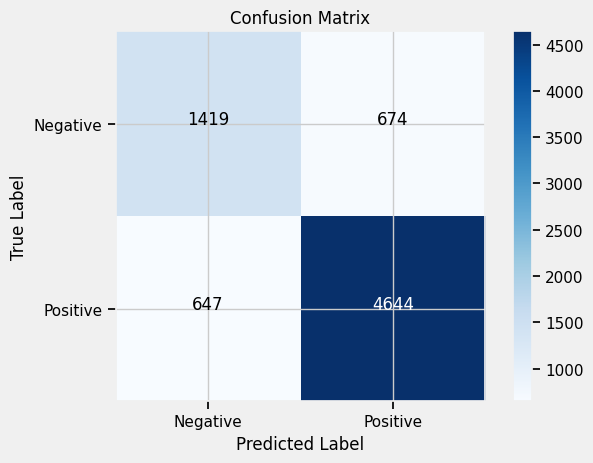

In [40]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np

# Logistic Regression
model_log = LogisticRegression()
model_log.fit(X_train_resample, y_train_resample)
y_pred = model_log.predict(X_test)

# Print data
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']  # List classes

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [41]:
y_test.value_counts()

not_fully_paid
1    5291
0    2093
Name: count, dtype: int64

In [42]:
# Use np.unique() to get unique values and count number of their appearances
unique_values, counts = np.unique(y_pred, return_counts=True)

# Print number of appearances of each value
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 2066
1: 5318


#Train model 02: Don't Upsampling and use XGBoost

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2093
           1       0.87      0.91      0.89      5291

    accuracy                           0.83      7384
   macro avg       0.80      0.78      0.79      7384
weighted avg       0.83      0.83      0.83      7384



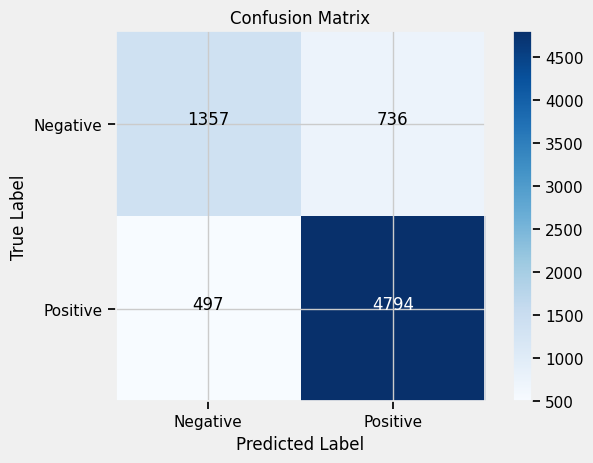

In [43]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(random_state = 42, n_estimators = 200)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

# Print result
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Negative', 'Positive']  # List Classes

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show Confusion Matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
